In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD


In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from tqdm import tqdm

In [4]:
import models
architecture = getattr(models, "Linear3NoBias") #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    True,
    train_random=False,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/Linear3NoBias/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/Linear3NoBias/curve4/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
model1.cuda();
model1.eval();
test_model(model1, loaders, cuda=True)

train results {'nll': 0.14886100863456725, 'loss': 0.14886100863456725, 'accuracy': 95.12}
test results {'nll': 2.030786293411255, 'loss': 2.030786293411255, 'accuracy': 62.54}


({'nll': 0.14886100863456725, 'loss': 0.14886100863456725, 'accuracy': 95.12},
 {'nll': 2.030786293411255, 'loss': 2.030786293411255, 'accuracy': 62.54})

In [6]:
model2.cuda();
model2.eval();
test_model(model2, loaders, cuda=True)

train results {'nll': 0.1461340056180954, 'loss': 0.1461340056180954, 'accuracy': 95.278}
test results {'nll': 2.016615950393677, 'loss': 2.016615950393677, 'accuracy': 63.44}


({'nll': 0.1461340056180954, 'loss': 0.1461340056180954, 'accuracy': 95.278},
 {'nll': 2.016615950393677, 'loss': 2.016615950393677, 'accuracy': 63.44})

In [7]:
def get_data(data_type='train'):

    layer = 0
    targ = []
    data = []
    for X, y in loaders[data_type]:
        data.append(X.view(-1,3*32*32).cpu().data.numpy())
        targ.append(y)
        
    data = np.concatenate(data)
    targ = np.concatenate(targ)
    
    return data, targ

In [8]:
data, targ = get_data(data_type='train')

l torch.Size([1024, 6144])


In [9]:
data.shape, targ.shape

((50000, 3072), (50000,))

In [13]:
data_test, targ_test = get_data(data_type='test')

l torch.Size([1024, 6144])


In [39]:
N_data = 10 #6144
data, targ = data[:N_data], targ[:N_data]

In [15]:
def next_layer(W, data):
    funcs = np.maximum(data @ W.T, 0)
    return funcs

    
def accuracy(pred, targ):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    return ens_acc

In [16]:
def get_model_weights(model):
    p = [list(model.parameters())[i].data.cpu().numpy() for i in range(len(list(model.parameters())))]
    return p

def get_model_from_weights(W, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W)  

    for parameter, w in zip(model_sampled.parameters(), W):
        parameter.data.copy_(torch.from_numpy(w))
            
    return model_sampled

In [28]:
class PointFinderSimultaneous():
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        self.weights_model1 = get_model_weights(model1)
        self.weights_model2 = get_model_weights(model2)
        self.depth = len(self.weights_model1)
        
    def find_point(self, t, method='arc_connect'):
        
        weights_model_new = []
        assert 0 <= t <= 1, 't must be between 0 and 1'
        for W1, W2 in zip(self.weights_model1, self.weights_model2):
            Wn = getattr(Connector(W1, W2), method)(t=t)[1]
            weights_model_new.append(Wn)
            
        m = get_model_from_weights(weights_model_new, architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train':res[0]['accuracy'], 'test': res[1]['accuracy']}

        return out

In [29]:
def get_stat(pointfinder, t=0.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(3, 9)):
        model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [30]:
# stat = get_stat(PointFinderSimultaneous, 0.5)

In [31]:
# np.array(stat['test']).mean(), np.array(stat['train']).mean()

In [36]:
class PointFinderStepWiseButterfly(PointFinderSimultaneous):
    def __init__(self, model1, model2):
        super().__init__(model1, model2)
        self.funcs1 = self.find_feature_maps(self.weights_model1, data)
        self.funcs2 = self.find_feature_maps(self.weights_model2, data)
        self.weights_adjusted = self.adjust_all_weights()

    def find_feature_maps(self, weights_model, data):
        """find feature maps for 2, 3 ,..., N-2 layers of network"""
        print('finding feature maps')
        funcs_list = []
        funcs = data
        for W in tqdm(list(weights_model)[:-2]):
            funcs = next_layer(W, data=funcs)
            funcs_list.append(funcs)
        return funcs_list
        
    def connect_butterflies(self, W10, W20, W11, W11b2,
                            t=0.5, method='arc_connect'):
        Wn0 = getattr(Connector(W10, W20), method)(t=t)[1]
        Wn1 = getattr(Connector(W11.T, W11b2.T), method)(t=t)[1].T
        return Wn0, Wn1
    
    def adjust_weights(self, f1, f2, W):
        f_inv2 = np.linalg.pinv(f2.T)
        Wb2 = W @ f1.T @ f_inv2
        return Wb2
        
    def adjust_all_weights(self, ):
        """find intermidiate weights between \Theta^A and \Theta^B (see the the paper for the notation) """
        print('adjusting weights')
        Wb2_list = []
        Wb2_list.append(self.weights_model1[0])
        for i, (f1, f2, W) in tqdm(enumerate(zip(self.funcs1, 
                                       self.funcs2, 
                                       self.weights_model1[1:-1]))):  
            Wb2 = self.adjust_weights(f1, f2, W)
            Wb2_list.append(Wb2)
        Wb2_list.append(self.weights_model2[-1])
        return Wb2_list
            
    def find_point(self, t=0.5, method='arc_connect'):
        
        layer = int(t // 1)
        t = t - layer
        if layer == self.depth - 1:
            layer -= 1
            t = 1
        assert layer <self.depth, 'the network is shot for this t value'
        W11 = self.weights_model1[layer+1]
        W20 = self.weights_model2[layer]
        W10 = self.weights_adjusted[layer]
        W11b2 = self.weights_adjusted[layer+1]
        Wn0, Wn1 = self.connect_butterflies(W10, W20, W11, W11b2,
                                            t=t, method=method)
        weights_model_t = self.weights_model2[:layer] + [Wn0, Wn1] + self.weights_model1[layer+2:]
        m = get_model_from_weights(weights_model_t, architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train':res[0]['accuracy'], 'test': res[1]['accuracy']}

        return out

In [23]:
linbutterfly = get_stat(PointFinderStepWiseButterfly, t=1.5, method='lin_connect')

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.54s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:44, 404.75s/it]


connect butterfly


 17%|█▋        | 1/6 [07:29<37:27, 449.52s/it]

train results {'nll': 1.5519071600341796, 'loss': 1.5519071600341796, 'accuracy': 46.738}
test results {'nll': 1.7943129163742066, 'loss': 1.7943129163742066, 'accuracy': 36.93}



  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.24s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:51, 411.10s/it]


connect butterfly


 33%|███▎      | 2/6 [15:04<30:05, 451.30s/it]

train results {'nll': 1.5088456756973267, 'loss': 1.5088456756973267, 'accuracy': 48.374}
test results {'nll': 1.7399790252685547, 'loss': 1.7399790252685547, 'accuracy': 39.17}



  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:11<00:00, 11.80s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:46, 406.29s/it]


connect butterfly


 50%|█████     | 3/6 [22:35<22:33, 451.19s/it]

train results {'nll': 1.517370428237915, 'loss': 1.517370428237915, 'accuracy': 48.088}
test results {'nll': 1.7433960430145263, 'loss': 1.7433960430145263, 'accuracy': 39.38}



  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.52s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:41, 401.21s/it]


connect butterfly


 67%|██████▋   | 4/6 [30:00<14:58, 449.34s/it]

train results {'nll': 1.4952188411331178, 'loss': 1.4952188411331178, 'accuracy': 49.036}
test results {'nll': 1.7285956281661987, 'loss': 1.7285956281661987, 'accuracy': 39.21}



  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:13<00:00, 13.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.61s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:37, 397.41s/it]


connect butterfly


 83%|████████▎ | 5/6 [37:26<07:28, 448.11s/it]

train results {'nll': 1.5365932415390016, 'loss': 1.5365932415390016, 'accuracy': 47.356}
test results {'nll': 1.7638778604507446, 'loss': 1.7638778604507446, 'accuracy': 38.12}



  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:12<00:00, 12.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 1/1 [00:13<00:00, 13.23s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:47, 407.83s/it]


connect butterfly


100%|██████████| 6/6 [44:59<00:00, 449.79s/it]

train results {'nll': 1.5415855751800538, 'loss': 1.5415855751800538, 'accuracy': 47.326}
test results {'nll': 1.7778395641326905, 'loss': 1.7778395641326905, 'accuracy': 37.75}


In [24]:
linbutterfly

{'test': [36.93, 39.17, 39.38, 39.21, 38.12, 37.75],
 'train': [46.738, 48.374, 48.088, 49.036, 47.356, 47.326]}

In [26]:
get_mean_svd(linbutterfly)

(47.81966666666667, 0.7623922146040645, 38.42666666666667, 0.9006417465094306)

In [53]:
finder = PointFinderStepWiseButterfly(model1, model2) 

  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps


  0%|          | 0/1 [00:00<?, ?it/s]

finding feature maps


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]
0it [00:00, ?it/s]

adjusting weights


1it [04:18, 258.21s/it]


In [54]:
finder.find_point(0)

connect butterfly
test results {'nll': 2.030786293411255, 'loss': 2.030786293411255, 'accuracy': 62.54}


{'train': 0, 'test': 62.54}

In [55]:
finder.find_point(1)

connect butterfly
test results {'nll': 2.0266584243774415, 'loss': 2.0266584243774415, 'accuracy': 62.31}


{'train': 0, 'test': 62.31}

In [56]:
finder.find_point(2)

connect butterfly
test results {'nll': 2.016615913772583, 'loss': 2.016615913772583, 'accuracy': 63.44}


{'train': 0, 'test': 63.44}

In [57]:
finder.find_point(0.5)

connect butterfly
test results {'nll': 3.9138029922485353, 'loss': 3.9138029922485353, 'accuracy': 52.54}


{'train': 0, 'test': 52.54}

In [58]:
finder.find_point(1.5)

connect butterfly
test results {'nll': 3.188697088623047, 'loss': 3.188697088623047, 'accuracy': 48.84}


{'train': 0, 'test': 48.84}

In [60]:
finder.find_point(0)

connect butterfly
train results {'nll': 0.14886100863456725, 'loss': 0.14886100863456725, 'accuracy': 95.12}
test results {'nll': 2.030786293411255, 'loss': 2.030786293411255, 'accuracy': 62.54}


{'train': 95.12, 'test': 62.54}

In [63]:
finder.find_point(1.5)

connect butterfly
train results {'nll': 0.14886100863456725, 'loss': 0.14886100863456725, 'accuracy': 95.12}
test results {'nll': 2.030786293411255, 'loss': 2.030786293411255, 'accuracy': 62.54}


{'train': 95.12, 'test': 62.54}

In [66]:
time = np.linspace(0, 2, 36)
time

array([0.        , 0.05714286, 0.11428571, 0.17142857, 0.22857143,
       0.28571429, 0.34285714, 0.4       , 0.45714286, 0.51428571,
       0.57142857, 0.62857143, 0.68571429, 0.74285714, 0.8       ,
       0.85714286, 0.91428571, 0.97142857, 1.02857143, 1.08571429,
       1.14285714, 1.2       , 1.25714286, 1.31428571, 1.37142857,
       1.42857143, 1.48571429, 1.54285714, 1.6       , 1.65714286,
       1.71428571, 1.77142857, 1.82857143, 1.88571429, 1.94285714,
       2.        ])

In [69]:
# time = np.linspace(0, 2, 36)
# path = {'test': [], 'train': []}
# for t in tqdm(time):
#     point = finder.find_point(t=t, method='arc_connect')
#     path['test'].append(100-point['test']) 
#     path['train'].append(100-point['train']) 

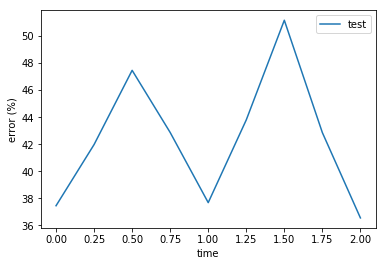

In [68]:
# plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [47]:
class PointFinderStepWiseInverse(PointFinderStepWiseButterfly):
    def __init__(self, model1, model2):
        super().__init__(model1, model2)

    def find_feature_maps(self, weights_model, data):
        """find feature maps of functions \theta_2^AB, ..., \theta_{N-1}^AB 
        (see the the paper for the notation)"""
        
        print('finding feature maps')
        funcs_list = []
        funcs = data
        funcs_list.append(funcs)
        for W in tqdm(list(weights_model)[:-1]):
            funcs = next_layer(W, data=funcs)
            funcs_list.append(funcs)
        return funcs_list
    
    def connect(self, W10, W20, t, method='arc_connect'):
        print('connect weights')
        Wn0 = getattr(Connector(W10, W20), method)(t=t)[1]
        return Wn0
        
    def adjust_all_weights(self, ):
        """adjust weights of the first model (model1) according to feature maps of model1, model2 
        in a way that resulting model will have the output of the model1 """
        
        print('adjusting weights')
        Wb2_list = []
        Wb2_list.append(self.weights_model1[0])
        for i, (f1, f2, W) in tqdm(enumerate(zip(self.funcs1[1:], 
                                       self.funcs2[1:], 
                                       self.weights_model1[1:]))):  
            Wb2 = self.adjust_weights(f1, f2, W)
            Wb2_list.append(Wb2)
        Wb2_list.append(self.weights_model2[-1])
        return Wb2_list
            
    def find_point(self, t=0.5, method='arc_connect'):
        
        layer = int(t // 1)
        t = t - layer
        if layer == self.depth:
            layer -= 1
            t = 1
        assert layer <= self.depth, 'the network is shot for this t value'
        
        W20 = self.weights_model2[layer]
        W10 = self.weights_adjusted[layer]
        Wn0 = self.connect(W10, W20, t=t, method=method)
        f1 = self.funcs1[layer+1]
        f2 = next_layer(self.funcs2[layer], Wn0) 
        W11 = self.weights_model1[layer+1]
        if t == 0 or t == 1:
            Wn1 = self.weights_adjusted[layer+1]
        else:
            Wn1 = self.adjust_weights(f1, f2, W11)
        
        weights_model_t = self.weights_model2[:layer] + [Wn0, Wn1] + self.weights_model1[layer+2:]
        m = get_model_from_weights(weights_model_t, architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train':res[0]['accuracy'], 'test': res[1]['accuracy']}
        return out

In [48]:
# class PointFinderStepWiseInverse():
#     def __init__(self, model1, model2):
        
#         self.model1 = model1
#         self.model2 = model2
#         self.weights_model1 = get_model_weights(model1)
#         self.weights_model2 = get_model_weights(model2)
#         self.depth = len(self.weights_model1)
#         self.funcs1 = self.find_feature_maps(self.weights_model1, data)
#         self.funcs2 = self.find_feature_maps(self.weights_model2, data)

#     def find_feature_maps(self, weights_model, data):
#         """find feature maps of functions starting from 1"""
        
#         print('finding feature maps')
#         funcs_list = []
#         funcs = data
#         funcs_list.append(funcs)
#         for W in list(weights_model)[:-1]:
#             print('-')
#             funcs = next_layer(W, data=funcs)
#             funcs_list.append(funcs)
#         return funcs_list
        
#     def connect(self, W10, W20, t=0.5, method='arc_connect'):
#         print('connect weights')
#         Wn0 = getattr(Connector(W10, W20), method)(t=s)[1]
#         return Wn0
    
#     def adjust_weights(self, f1, f2, W):
#         f_inv2 = np.linalg.pinv(f2.T)
#         Wb2 = W @ f1.T @ f_inv2
#         return Wb2
        
            
#     def find_point(self, t=0.5, method='arc_connect'):
        
#         layer = t // 1
#         assert layer <self.depth, 'the network is shot for this t value'
#         t = t - layer
#         W10, W11 = self.weights_model1[layer:layer+2]
#         Wn0 = self.connect(W10, W20,t=t, method=method)
#         W20 = self.weights_model2[layer:layer+1]
#         f1 = self.funcs1[layer+1]
#         f2 = self.funcs2[layer-1]
#         Wn1 = self.adjust_weights(f1, f2, W20)
        
#         weights_model_t = self.weights_model2[:layer] + [Wn0, Wn1] + self.weights_model1[layer+2:]
#         m = get_model_from_weights(weights_model_t, architecture)
#         m.cuda();
#         res = test_model(model1, loaders, cuda=True)
#         out = {'train':res[0]['accuracy'], 'test': res[1]['accuracy']}

#         return out

In [49]:
finder = PointFinderStepWiseInverse(model1, model2) 


100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
0it [00:00, ?it/s]
1it [00:00,  9.57it/s]

finding feature maps
finding feature maps
adjusting weights



2it [00:00,  7.06it/s]


In [51]:
finder.find_point(0.5)

connect weights


ValueError: shapes (2000,10) and (6144,10) not aligned: 10 (dim 1) != 6144 (dim 0)

In [ ]:
finder

In [ ]:
# simple layerwise conection for 3d 

model1.cuda()
model2.cuda()
acc_train = []
acc_test = []
t = 0.5
stat = {'train': [], 'test': []}
for i in tqdm(range(3, 10)):
    model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
    model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])

    W10 = list(model1.parameters())[0].data.cpu().numpy()
    W20 = list(model2.parameters())[0].data.cpu().numpy()

    W11 = list(model1.parameters())[-2].data.cpu().numpy()
    W21 = list(model2.parameters())[-2].data.cpu().numpy()

    W12 = list(model1.parameters())[-1].data.cpu().numpy()
    W22 = list(model2.parameters())[-1].data.cpu().numpy()
    
#     W2n = Connector(W12.T, W22.T).arc_connect(t=t)[1].T
#     W1n = Connector(W11.T, W21.T).arc_connect(t=t)[1].T
#     W0n = Connector(W10.T, W20.T).arc_connect(t=t)[1].T
    
    W2n = Connector(W12, W22).lin_connect(t=t)[1]
    W1n = Connector(W11, W21).lin_connect(t=t)[1]
    W0n = Connector(W10, W20).lin_connect(t=t)[1]
    
#     W2n = Connector(W12, W22).arc_connect(t=t)[1]
#     W1n = Connector(W11.T, W21.T).arc_connect(t=t)[1].T
#     W0n = Connector(W10, W20).arc_connect(t=t)[1]
    
    pred = W2n @ np.maximum(W1n @ np.maximum(W0n @ data.T, 0), 0)
    acc = accuracy(pred.T, targ)
    acc_train.append(acc)
    
    pred = W2n @ np.maximum(W1n @ np.maximum(W0n @ data_test.T, 0), 0)
    acc = accuracy(pred.T, targ_test)
    acc_test.append(acc)
    
acc_train = np.array(acc_train)
acc_test = np.array(acc_test)


In [38]:
model1.cuda()
model2.cuda()
acc_train = []
acc_test = []
t = 0.5
stat = {'train': [], 'test': []}
for i in tqdm(range(3, 10)):
    model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
    model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])

    W10 = list(model1.parameters())[0].data.cpu().numpy()
    W20 = list(model2.parameters())[0].data.cpu().numpy()

    W11 = list(model1.parameters())[-2].data.cpu().numpy()
    W21 = list(model2.parameters())[-2].data.cpu().numpy()

    W12 = list(model1.parameters())[-1].data.cpu().numpy()
    W22 = list(model2.parameters())[-1].data.cpu().numpy()
    
#     W2n = Connector(W12.T, W22.T).arc_connect(t=t)[1].T
#     W1n = Connector(W11.T, W21.T).arc_connect(t=t)[1].T
#     W0n = Connector(W10.T, W20.T).arc_connect(t=t)[1].T
    
    W2n = Connector(W12, W22).lin_connect(t=t)[1]
    W1n = Connector(W11, W21).lin_connect(t=t)[1]
    W0n = Connector(W10, W20).lin_connect(t=t)[1]
    
#     W2n = Connector(W12, W22).arc_connect(t=t)[1]
#     W1n = Connector(W11.T, W21.T).arc_connect(t=t)[1].T
#     W0n = Connector(W10, W20).arc_connect(t=t)[1]
    
    pred = W2n @ np.maximum(W1n @ np.maximum(W0n @ data.T, 0), 0)
    acc = accuracy(pred.T, targ)
    acc_train.append(acc)
    
    pred = W2n @ np.maximum(W1n @ np.maximum(W0n @ data_test.T, 0), 0)
    acc = accuracy(pred.T, targ_test)
    acc_test.append(acc)
    
acc_train = np.array(acc_train)
acc_test = np.array(acc_test)




  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:07<00:46,  7.83s/it]

 29%|██▊       | 2/7 [00:15<00:39,  7.83s/it]

 43%|████▎     | 3/7 [00:23<00:31,  7.83s/it]

 57%|█████▋    | 4/7 [00:31<00:23,  7.83s/it]

 71%|███████▏  | 5/7 [00:39<00:15,  7.83s/it]

 86%|████████▌ | 6/7 [00:46<00:07,  7.83s/it]

100%|██████████| 7/7 [00:54<00:00,  7.83s/it]



In [39]:
acc_train

array([29.808, 31.914, 32.098, 32.012, 30.91 , 30.298, 30.706])

In [40]:
acc_test

array([25.47, 27.71, 28.94, 27.67, 28.01, 26.21, 26.38])

In [41]:
acc_train.mean(), acc_train.std(), acc_test.mean(), acc_test.std()

(31.106571428571424, 0.8446339625022451, 27.19857142857143, 1.1218661566645942)

In [30]:
acc_train.mean(), acc_train.std(), acc_test.mean(), acc_test.std()

(46.398, 1.0352705650491292, 40.17285714285714, 0.8496674019153343)

In [28]:
acc_train.mean(), acc_train.std(), acc_test.mean(), acc_test.std()

(44.5, 0.6738511917118114, 37.55142857142857, 0.7603651110097153)

In [111]:
# data = data[:2000]
# targ = targ[:2000]

In [112]:
# pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11 @ np.maximum(W10 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [113]:
# pred = W22 @ np.maximum(W21 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W22 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [114]:
# funcs1 = next_layer(W10, data=data)
# funcs2  = next_layer(W20, data=data)

In [115]:
# f_inv2 = np.linalg.pinv(funcs2.T)
# W11b2 = W11 @ funcs1.T @ f_inv2

In [116]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [117]:
# funcs12 = next_layer(W11, data=funcs1)
# funcs22  = next_layer(W21, data=funcs2)

In [118]:
# f_inv22 = np.linalg.pinv(funcs22.T)
# W12b2 = W12 @ funcs12.T @ f_inv22

In [119]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12b2 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [120]:
# print(W10.shape, W11.shape, W12.shape)

In [121]:
class PointFinder():
    def __init__(self, model1, model2):
        
        self.model1 = model1
        self.model2 = model2
        self.depth = 
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs1 = next_layer(self.W10, data=data)
        self.funcs2  = next_layer(self.W20, data=data)
        self.f_inv2 = np.linalg.pinv(self.funcs2.T)
        self.W11b2 = self.W11 @ self.funcs1.T @ self.f_inv2
        
    def connect_butterflies(self, W10, W20, W11, W11b2,
                            t=0.5, method='arc_connect'):
        Wn0 = getattr(Connector(W10, W20), method)(t=s)[1]
        Wn1 = getattr(Connector(W11.T, W11b2.T), method)(t=s)[1].T

        return Wn0, Wn1

    def find_point(self, t=0.5, method='arc_connect'):
        
        for 

        out = {}
        if 0<=t<1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            Wn1 = getattr(Connector(self.W11.T, self.W11b2.T), method)(t=s)[1].T
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
        elif 1<=t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
            Wn2 = getattr(Connector(self.W12.T, self.W22.T), method)(t=s)[1].T
            
            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
  
        else:
            assert not  0<=t<=2, 't is not in [0, 2]'

        return out

In [122]:
class PointFinderInverse():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs11 = next_layer(self.W10, data=data)
        self.funcs12 = next_layer(self.W11, data=self.funcs11)
        
        self.funcs21 = next_layer(self.W20, data=data)
        self.funcs22 = next_layer(self.W21, data=self.funcs21)
        
        self.f_inv21 = np.linalg.pinv(self.funcs21.T)
        self.W11b2 = self.W11 @ self.funcs11.T @ self.f_inv21
        
        self.f_inv22 = np.linalg.pinv(self.funcs22.T)
        self.W12b2 = self.W12 @ self.funcs12.T @ self.f_inv22
        
    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            
            funcs = next_layer(Wn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)

        elif 1<t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]

            funcs = next_layer(Wn1, data=self.funcs21)
            f_inv = np.linalg.pinv(funcs.T)
            Wn2 = self.W12 @ self.funcs12.T @ f_inv

            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        elif 2<t<=3:
            s = t - 2
            Wn1 = getattr(Connector(self.W12b2, self.W22), method)(t=s)[1]
               
            pred = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        else:
            assert not  0<=t<=3, 't is not in [0, 3]'
            
        print(t, out)

        return out

# Path Visualization 

In [123]:
finder = PointFinderInverse(model1, model2) 
# finder = PointFinder(model1, model2)

In [84]:
point = finder.find_point(t=0, method='arc_connect')

0 {'train': 98.095703125, 'test': 64.4}


In [85]:
point

{'train': 98.095703125, 'test': 64.4}

In [86]:
point1 = finder.find_point(t=1, method='arc_connect')
point1

1 {'train': 98.03059895833334, 'test': 10.27}


{'train': 98.03059895833334, 'test': 10.27}

In [87]:
point2 = finder.find_point(t=2, method='arc_connect')
point2

2 {'train': 98.095703125, 'test': 10.79}


{'train': 98.095703125, 'test': 10.79}

In [88]:
point3 = finder.find_point(t=2.5, method='arc_connect')
point3

2.5 {'train': 98.86067708333334, 'test': 11.600000000000001}


{'train': 98.86067708333334, 'test': 11.600000000000001}

In [130]:
time = np.linspace(0, 2, 9)

In [132]:
time = list(time) + [2.5, 3] 

In [133]:
time

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3]

In [134]:
point

{'train': 98.095703125, 'test': 10.79}

In [135]:
time = np.linspace(0, 2, 9)
path = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='arc_connect')
    path['test'].append(100-point['test']) 
    path['train'].append(100-point['train']) 

  9%|▉         | 1/11 [02:09<21:32, 129.25s/it]

0.0 {'train': 97.68599999999999, 'test': 64.4}


 18%|█▊        | 2/11 [04:18<19:23, 129.26s/it]

0.25 {'train': 97.404, 'test': 64.01}


 27%|██▋       | 3/11 [06:27<17:13, 129.19s/it]

0.5 {'train': 96.878, 'test': 63.839999999999996}


 36%|███▋      | 4/11 [08:36<15:04, 129.17s/it]

0.75 {'train': 96.746, 'test': 63.7}


 45%|████▌     | 5/11 [10:45<12:54, 129.13s/it]

1.0 {'train': 96.808, 'test': 63.739999999999995}


 55%|█████▍    | 6/11 [12:46<10:33, 126.71s/it]

1.25 {'train': 92.268, 'test': 62.8}


 64%|██████▎   | 7/11 [14:47<08:19, 125.00s/it]

1.5 {'train': 83.91, 'test': 61.71}


 73%|███████▎  | 8/11 [16:48<06:11, 123.83s/it]

1.75 {'train': 89.932, 'test': 63.2}


 82%|████████▏ | 9/11 [18:49<04:06, 123.00s/it]

2.0 {'train': 94.774, 'test': 64.05999999999999}


 91%|█████████ | 10/11 [19:02<01:29, 89.73s/it]

2.5 {'train': 97.234, 'test': 65.11}


100%|██████████| 11/11 [19:14<00:00, 66.44s/it]

3 {'train': 97.832, 'test': 64.66}


In [136]:
100 - np.array(path['train'])

array([97.686, 97.404, 96.878, 96.746, 96.808, 92.268, 83.91 , 89.932,
       94.774, 97.234, 97.832])

In [137]:
100 - np.array(path['test'])

array([64.4 , 64.01, 63.84, 63.7 , 63.74, 62.8 , 61.71, 63.2 , 64.06,
       65.11, 64.66])

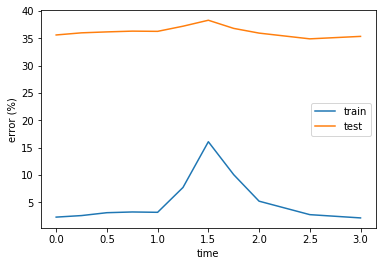

In [138]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [36]:
path_l = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='lin_connect')
    path_l['test'].append(100-point['test']) 
    path_l['train'].append(100-point['train']) 

100%|██████████| 61/61 [07:43<00:00,  7.45s/it]


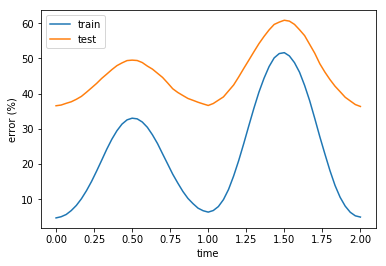

In [37]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [45]:
def get_stat(pointfinder, t=1.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(3, 9)):
        model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [46]:
arcbutterfly = get_stat(PointFinder, t=1.5, method='arc_connect')


100%|██████████| 6/6 [12:07<00:00, 121.25s/it]


In [49]:
arcbutterfly

{'test': [48.77, 50.42, 49.46, 51.32, 49.09, 48.82],
 'train': [59.931999999999995,
  60.978,
  60.397999999999996,
  62.21600000000001,
  60.01,
  60.124]}

In [25]:
def get_mean_svd(stat):
    train = np.array(stat['train'])
    test = np.array(stat['test'])
    return train.mean(), train.std(), test.mean(), test.std()

In [53]:
get_mean_svd(arcbutterfly)

(60.60966666666667, 0.7974420912448094, 49.64666666666667, 0.930477774527091)

In [54]:
linbutterfly = get_stat(PointFinder, t=1.5, method='lin_connect')


100%|██████████| 6/6 [12:06<00:00, 121.03s/it]


In [55]:
linbutterfly

{'test': [36.93, 39.17, 39.379999999999995, 39.21, 38.12, 37.75],
 'train': [46.738,
  48.374,
  48.087999999999994,
  49.036,
  47.355999999999995,
  47.326]}

In [56]:
get_mean_svd(linbutterfly)

(47.81966666666667, 0.7623922146040647, 38.42666666666667, 0.9006417465094294)

In [57]:
linpseudo = get_stat(PointFinderInverse, t=1.5, method='lin_connect')


 17%|█▋        | 1/6 [02:26<12:13, 146.64s/it]

1.5 {'train': 61.026, 'test': 51.839999999999996}



 33%|███▎      | 2/6 [04:53<09:46, 146.74s/it]

1.5 {'train': 60.948, 'test': 51.64}



 50%|█████     | 3/6 [07:20<07:20, 146.78s/it]

1.5 {'train': 60.784000000000006, 'test': 51.68000000000001}



 67%|██████▋   | 4/6 [09:47<04:53, 146.83s/it]

1.5 {'train': 61.419999999999995, 'test': 52.18000000000001}



 83%|████████▎ | 5/6 [12:14<02:26, 146.83s/it]

1.5 {'train': 60.846000000000004, 'test': 52.23}



100%|██████████| 6/6 [14:41<00:00, 146.84s/it]


1.5 {'train': 60.57599999999999, 'test': 51.68000000000001}


In [63]:
linpseudo

{'test': [51.839999999999996,
  51.64,
  51.68000000000001,
  52.18000000000001,
  52.23,
  51.68000000000001],
 'train': [61.026,
  60.948,
  60.784000000000006,
  61.419999999999995,
  60.846000000000004,
  60.57599999999999]}

In [64]:
get_mean_svd(linpseudo)

(60.93333333333334, 0.2592493437257302, 51.875, 0.2420571557848809)

In [ ]:
arcpseudo = get_stat(PointFinderInverse, t=1.5, method='arc_connect')


 17%|█▋        | 1/6 [02:26<12:14, 146.96s/it]

1.5 {'train': 71.096, 'test': 59.47}


In [65]:
arcpseudo

{'test': [59.47,
  59.38,
  58.540000000000006,
  58.95,
  58.650000000000006,
  58.699999999999996],
 'train': [71.096, 71.356, 70.706, 71.394, 71.134, 70.922]}

In [66]:
get_mean_svd(arcpseudo)

(71.10133333333334,
 0.23806628395376653,
 58.94833333333333,
 0.35960240389753795)

In [59]:
f_inv1 = np.linalg.pinv(funcs1.T)

In [60]:
f_inv2 = np.linalg.pinv(funcs2.T)

In [62]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [70]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [64]:
t=0.5
pred = Connector(W12.T, W22.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W11, (W21 @ funcs2.T @ f_inv1)).arc_connect(t=t)[1] @  np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

61.07

In [65]:
t = 0.5
pred = W22 @ np.maximum(Connector((W21 @ funcs2.T @ f_inv1).T, W21.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W10, W20).arc_connect(t=t)[1]  @ data.T, 0), 0)
accuracy(pred.T, targ)

78.448